# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [25]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [26]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

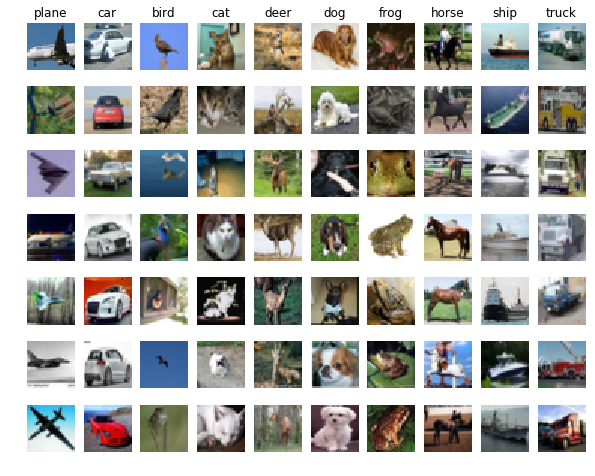

In [27]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

<Ответ> Большее число слоев. Использование shortcut'ов для борьбы с затуханием градиентов. Использование Batch Normalization. В целом более сложная архитектура большой с глубины с множеством параллельных блоков.

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ>  Затухание градиента. Против этого используем residual connections. Также возможно возникновение переобучения. Избежать этого помогает dropout.


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ> Надо бороться с переобучениями. Сложные модели легко запоминают маленькие выборки. В борьбе с этим может помочь Data Augmentation, DropOut, DropConnect, Gradient Clipping, использование регуляризации. Уменьшить размер сети.

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ> Звук преобразуется в спектрограмму с помощью преобразования Фурье. Спектрограмма представляет собой двумерное представление 1D-сигнала, поэтому его можно рассматривать как изображение. Или лучше думать о спектрограмме как о изображении 1xT с F-каналами.  Мы не можем просто использовать VGG-19, так как 3x3-свертки не подходят для нашей существенно одномерной задачи, для которой мы наверняка хотим использовать 1D-свертки. Тогда есть два варианта: использовать предварительно настроенную сеть или использовать полностью случайные веса.

In [28]:
import lasagne
import keras 
from theano import tensor as T
from lasagne.nonlinearities import *
from keras.preprocessing.image import ImageDataGenerator
input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

## Data Augmentation и VGG-19

In [30]:
X_train = np.array(X_train, dtype = np.float32)
X_test = np.array(X_test, dtype = np.float32)
y_train = np.array(y_train, dtype = np.int32)
y_test = np.array(y_test, dtype = np.int32)

#Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    data_format="channels_first")

datagen.fit(X_train)

#Архитектура VGG-19 
net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

net = lasagne.layers.Conv2DLayer(net, 64, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.Conv2DLayer(net, 64, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.BatchNormLayer(net, axes = 'auto')
net = lasagne.layers.MaxPool2DLayer(net, (2,2))

net = lasagne.layers.Conv2DLayer(net, 128, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.Conv2DLayer(net, 128, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.BatchNormLayer(net, axes = 'auto')
net = lasagne.layers.MaxPool2DLayer(net, (2,2))

net = lasagne.layers.Conv2DLayer(net, 256, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.Conv2DLayer(net, 256, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.Conv2DLayer(net, 256, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.BatchNormLayer(net, axes = 'auto')
net = lasagne.layers.MaxPool2DLayer(net, (2,2))

net = lasagne.layers.Conv2DLayer(net, 512, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.Conv2DLayer(net, 512, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.Conv2DLayer(net, 512, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.Conv2DLayer(net, 512, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.BatchNormLayer(net, axes = 'auto')
net = lasagne.layers.MaxPool2DLayer(net, (2,2))

net = lasagne.layers.Conv2DLayer(net, 512, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.Conv2DLayer(net, 512, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.Conv2DLayer(net, 512, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.Conv2DLayer(net, 512, (3,3), nonlinearity=rectify, pad='same')
net = lasagne.layers.BatchNormLayer(net, axes = 'auto')
net = lasagne.layers.MaxPool2DLayer(net, (2,2))

net = lasagne.layers.DenseLayer(lasagne.layers.dropout(net, p=0.5), num_units=4096)
net = lasagne.layers.DenseLayer(lasagne.layers.dropout(net, p=0.5), num_units=4096)
net = lasagne.layers.DenseLayer(lasagne.layers.dropout(net, p=0.5), num_units=1000)

net = lasagne.layers.DenseLayer(net,num_units = 10, nonlinearity=softmax)

In [31]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print all_weights

[W, b, W, b, beta, gamma, W, b, W, b, beta, gamma, W, b, W, b, W, b, beta, gamma, W, b, W, b, W, b, W, b, beta, gamma, W, b, W, b, W, b, W, b, beta, gamma, W, b, W, b, W, b, W, b]


In [32]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
all_layers = lasagne.layers.get_all_layers(net)
l2_= lasagne.regularization.regularize_layer_params(all_layers, lasagne.regularization.l2) * 0.0001
loss = loss + l2_

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [33]:
%%capture
lr = 0.0001
sh_lr = theano.shared(lasagne.utils.floatX(lr))

updates = lasagne.updates.adam(loss, all_weights, learning_rate=sh_lr);
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True);
accuracy_fun = theano.function([input_X,target_y], accuracy, allow_input_downcast=True);

### Вот и всё, пошли её учить

In [34]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [37]:
X_train = np.array(X_train, dtype = np.float32)
X_test = np.array(X_test, dtype = np.float32)
y_train = np.array(y_train, dtype = np.int32)
y_test = np.array(y_test, dtype = np.int32)

# Процесс обучения

In [39]:
import time

num_epochs = 25 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    if (epoch % 5 == 0 and epoch > 0):
        new_lr = sh_lr.get_value() / 2
        sh_lr.set_value(lasagne.utils.floatX(new_lr))
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for inputs, targets in datagen.flow(X_train, y_train, batch_size= batch_size):
        inputs = inputs.astype(np.int32)
        targets = targets.astype(np.int32)
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1
        if train_batches > 500:
            break

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
      
    for inputs, targets in datagen.flow(X_test, y_test, batch_size=batch_size):
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1
        if val_batches > 500:
            break

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 25 took 603.453s
  training loss (in-iteration):		3.344325
  train accuracy:		45.23 %
  validation accuracy:		55.26 %
Epoch 2 of 25 took 607.058s
  training loss (in-iteration):		2.563563
  train accuracy:		55.82 %
  validation accuracy:		63.34 %
Epoch 3 of 25 took 603.045s
  training loss (in-iteration):		2.110683
  train accuracy:		66.02 %
  validation accuracy:		70.47 %
Epoch 4 of 25 took 606.845s
  training loss (in-iteration):		1.805859
  train accuracy:		73.69 %
  validation accuracy:		74.03 %
Epoch 5 of 25 took 605.445s
  training loss (in-iteration):		1.493062
  train accuracy:		74.39 %
  validation accuracy:		76.11 %
Epoch 6 of 25 took 604.903s
  training loss (in-iteration):		1.351492
  train accuracy:		77.50 %
  validation accuracy:		77.81 %
Epoch 7 of 25 took 609.016s
  training loss (in-iteration):		1.281082
  train accuracy:		79.55 %
  validation accuracy:		78.91 %
Epoch 8 of 25 took 608.483s
  training loss (in-iteration):		1.145603
  train accuracy:		80.09 %


### Злые языки в интернете говорили, что артитектура дает на cifar-10 результат - 92.64%. Но у нас что-то пошло не так(

In [42]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		90.14 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 